In [54]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount('/content/drive')

In [55]:
# Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [56]:
# Prepare data
data = pd.read_csv("/content/new.csv")

# X = data[['temp_3 (°C)', 'SR (W/mt2)', 'metric_date', 'metric_time', 'calculated_power', 'dust_conc']]
X = data[['temp_3 (Â°C)', 'SR (W/mt2)', 'PM2.5 (Âµg/mÂ³)', 'WS (m/s)', 'PM10 (Âµg/mÂ³)', 'NO2 (Âµg/mÂ³)', 'AC CURRENT-1 (A)', 'AC VOLTAGE-3 (V)', 'metric_date']]

y = data['AC POWER-3 (W)']
X_train = X
y_train = y
# Convert 'metric_date' to numerical value
X_train['metric_date'] = pd.to_datetime(X_train['metric_date']).map(pd.Timestamp.toordinal)
print(X_train.shape, y_train.shape)
print(X_train.head(5))

(79541, 9) (79541,)
   temp_3 (Â°C)  SR (W/mt2)  PM2.5 (Âµg/mÂ³)  WS (m/s)  PM10 (Âµg/mÂ³)  \
0           0.0         4.4           167.73      0.11          346.13   
1           0.0         3.9           167.73      0.11          346.13   
2           0.0         4.1           167.73      0.11          346.13   
3           0.0         4.2           167.62      0.08          346.05   
4           0.0         4.6           157.52      0.11          338.69   

   NO2 (Âµg/mÂ³)  AC CURRENT-1 (A)  AC VOLTAGE-3 (V)  metric_date  
0          36.68               0.0               0.0       737791  
1          35.11               0.0               0.0       737791  
2          35.05               0.0               0.0       737791  
3          35.38               0.0               0.0       737791  
4          34.89               0.0               0.0       737791  


<ipython-input-56-20c1265b2f83>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['metric_date'] = pd.to_datetime(X_train['metric_date']).map(pd.Timestamp.toordinal)


In [57]:
# Prepare data
data = pd.read_csv("/content/test.csv")

# Define features and target
X = data[['temp_3 (Â°C)', 'SR (W/mt2)', 'PM2.5 (Âµg/mÂ³)', 'WS (m/s)', 'PM10 (Âµg/mÂ³)', 'NO2 (Âµg/mÂ³)', 'AC CURRENT-1 (A)', 'AC VOLTAGE-3 (V)', 'metric_date']]


y = data['AC POWER-3 (W)']
X_test = X
y_test = y
print(X_test.shape, y_test.shape)
print(X_test.head(5))

(481, 9) (481,)
   temp_3 (Â°C)  SR (W/mt2)  PM2.5 (Âµg/mÂ³)  WS (m/s)  PM10 (Âµg/mÂ³)  \
0          27.1         4.4            535.7      0.06           535.7   
1          27.1         4.4            520.2      0.09           520.2   
2          27.1         4.5            519.9      0.10           519.9   
3          27.1         4.5            519.9      0.10           519.9   
4          27.1         4.7            519.9      0.10           519.9   

   NO2 (Âµg/mÂ³)  AC CURRENT-1 (A)  AC VOLTAGE-3 (V) metric_date  
0          37.46               0.0               0.0  2023-12-27  
1          35.44               0.0               0.0  2023-12-27  
2          34.43               0.0               0.0  2023-12-27  
3          28.91               0.0               0.0  2023-12-27  
4          34.33               0.0               0.0  2023-12-27  


In [58]:
# Convert y_test back to DataFrame to retain indices
y_test = pd.DataFrame(y_test, index=X_test.index, columns=['AC POWER-3 (W)'])

# Convert 'metric_date' to numerical value
# X_train['metric_date'] = X_train['metric_date'].map(pd.Timestamp.toordinal)
X_test['metric_date'] = pd.to_datetime(X_test['metric_date']).map(pd.Timestamp.toordinal)


# Scale the features
scaler = StandardScaler()

# X_train[' metric_time'] = pd.to_timedelta(X_train[' metric_time']).dt.total_seconds()
# X_train = X_train.drop([' metric_time'], axis=1)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure X_test retains index after scaling
X_test = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)

# Function to ensure predictions are never less than zero
def ensure_non_zero(predictions):
    return np.maximum(predictions, 0)

<ipython-input-58-df966a538cdb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['metric_date'] = pd.to_datetime(X_test['metric_date']).map(pd.Timestamp.toordinal)


In [59]:
# Function to evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = ensure_non_zero(y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, mae, r2

# Linear Regression
linear_model = LinearRegression()
linear_mse, linear_rmse, linear_mae, linear_r2 = evaluate_model(linear_model, X_train, X_test, y_train, y_test)

# Polynomial Regression
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
poly_model = LinearRegression()
poly_mse, poly_rmse, poly_mae, poly_r2 = evaluate_model(poly_model, X_train_poly, X_test_poly, y_train, y_test)

# Ridge Regression
ridge_model = Ridge()
ridge_param_grid = {'alpha': [0.1, 1.0, 10.0]}
ridge_grid_search = GridSearchCV(estimator=ridge_model, param_grid=ridge_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)
ridge_best_model = ridge_grid_search.best_estimator_
ridge_mse, ridge_rmse, ridge_mae, ridge_r2 = evaluate_model(ridge_best_model, X_train, X_test, y_train, y_test)

# Lasso Regression
lasso_model = Lasso()
lasso_param_grid = {'alpha': [0.1, 1.0, 10.0]}
lasso_grid_search = GridSearchCV(estimator=lasso_model, param_grid=lasso_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)
lasso_best_model = lasso_grid_search.best_estimator_
lasso_mse, lasso_rmse, lasso_mae, lasso_r2 = evaluate_model(lasso_best_model, X_train, X_test, y_train, y_test)

# Decision Tree Regression
tree_model = DecisionTreeRegressor(random_state=42)
tree_mse, tree_rmse, tree_mae, tree_r2 = evaluate_model(tree_model, X_train, X_test, y_train, y_test)

# Random Forest Regression
forest_model = RandomForestRegressor(random_state=42, n_jobs=-1)
forest_mse, forest_rmse, forest_mae, forest_r2 = evaluate_model(forest_model, X_train, X_test, y_train, y_test)

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor(random_state=42)
gb_mse, gb_rmse, gb_mae, gb_r2 = evaluate_model(gb_model, X_train, X_test, y_train, y_test)

# Print results for individual models
print("Linear Regression:")
print(f"MSE: {linear_mse}, RMSE: {linear_rmse}, MAE: {linear_mae}, R2: {linear_r2}\n")

print("Polynomial Regression:")
print(f"MSE: {poly_mse}, RMSE: {poly_rmse}, MAE: {poly_mae}, R2: {poly_r2}\n")

print("Ridge Regression:")
print(f"MSE: {ridge_mse}, RMSE: {ridge_rmse}, MAE: {ridge_mae}, R2: {ridge_r2}")
print(f"Best Parameters: {ridge_grid_search.best_params_}\n")

print("Lasso Regression:")
print(f"MSE: {lasso_mse}, RMSE: {lasso_rmse}, MAE: {lasso_mae}, R2: {lasso_r2}")
print(f"Best Parameters: {lasso_grid_search.best_params_}\n")

print("Decision Tree Regression:")
print(f"MSE: {tree_mse}, RMSE: {tree_rmse}, MAE: {tree_mae}, R2: {tree_r2}\n")

print("Random Forest Regression:")
print(f"MSE: {forest_mse}, RMSE: {forest_rmse}, MAE: {forest_mae}, R2: {forest_r2}\n")

print("Gradient Boosting Regression:")
print(f"MSE: {gb_mse}, RMSE: {gb_rmse}, MAE: {gb_mae}, R2: {gb_r2}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Linear Regression:
MSE: 1007534.6484749567, RMSE: 1003.760254480599, MAE: 963.8717811001153, R2: 0.6676589143596381

Polynomial Regression:
MSE: 41771.30413245642, RMSE: 204.38029291606472, MAE: 101.70129653326447, R2: 0.9862214956229971

Ridge Regression:
MSE: 1007554.0803948803, RMSE: 1003.769933996272, MAE: 963.8811891809321, R2: 0.6676525046293392
Best Parameters: {'alpha': 0.1}

Lasso Regression:
MSE: 1007026.1587309052, RMSE: 1003.506930086138, MAE: 963.6191927741253, R2: 0.667826642619734
Best Parameters: {'alpha': 0.1}

Decision Tree Regression:
MSE: 7447.388773388773, RMSE: 86.29825475285566, MAE: 40.83575883575884, R2: 0.9975434360754936

Random Forest Regression:
MSE: 3331.8496534303536, RMSE: 57.722176443983415, MAE: 29.14488565488566, R2: 0.9989009702716551

Gradient Boosting Regression:
MSE: 153636.19418404254, RMSE: 391.96453179342967, MAE: 203.35706458199917, R2: 0.9493222196913387



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


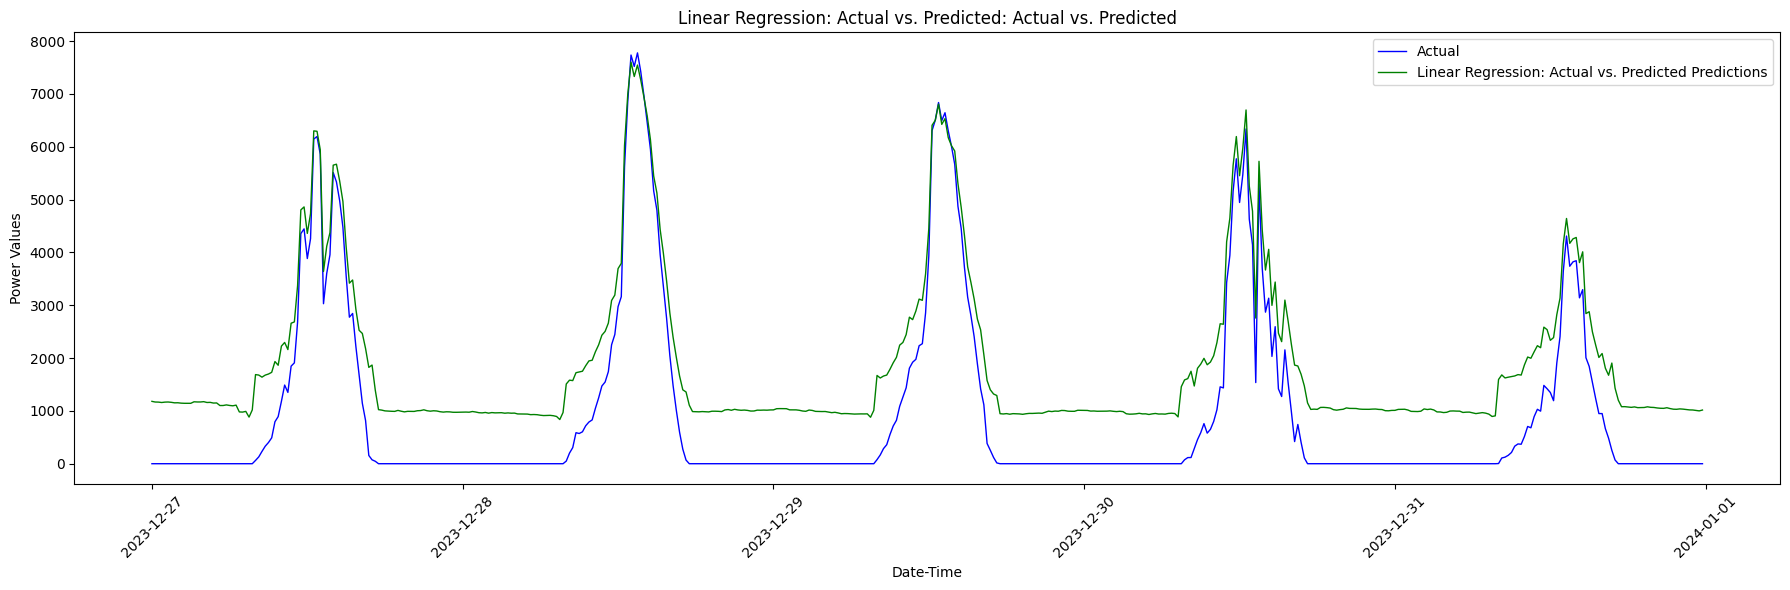

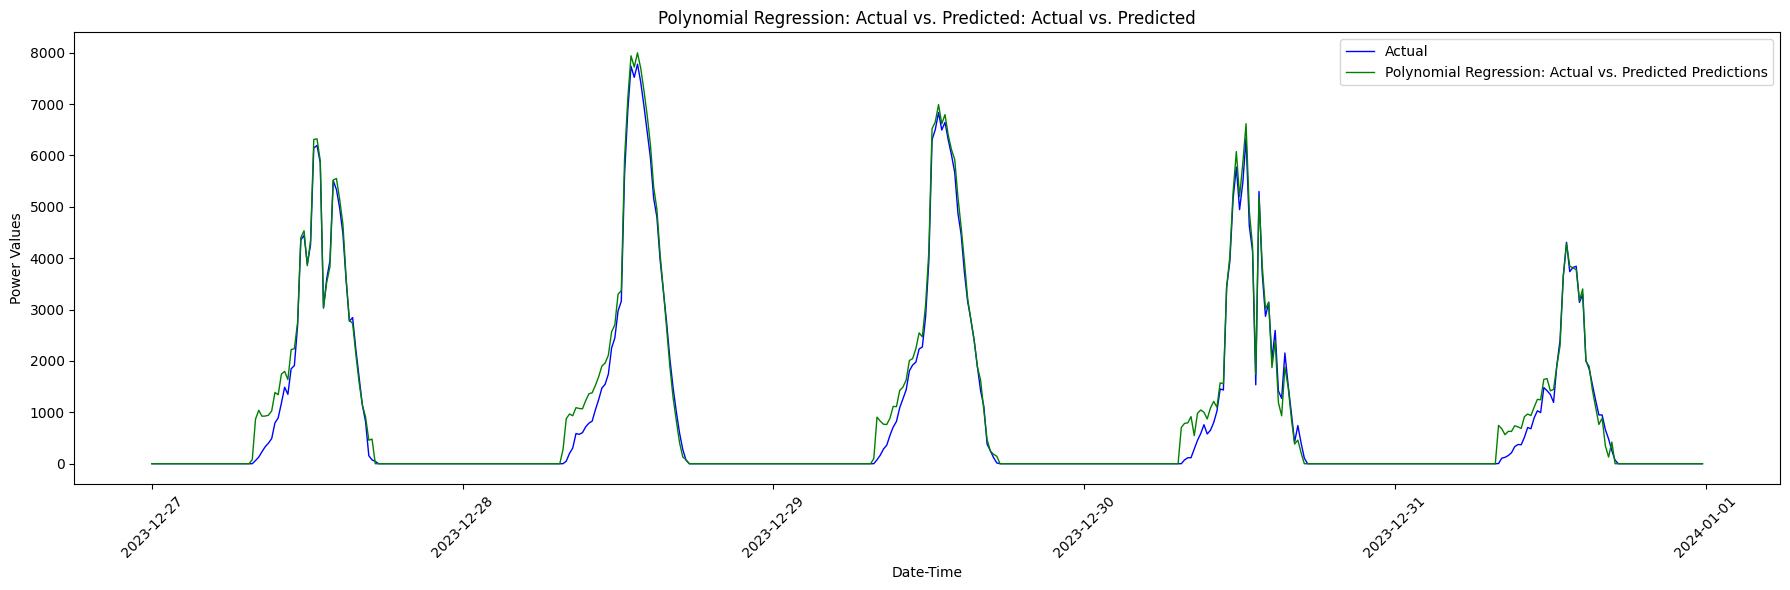

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


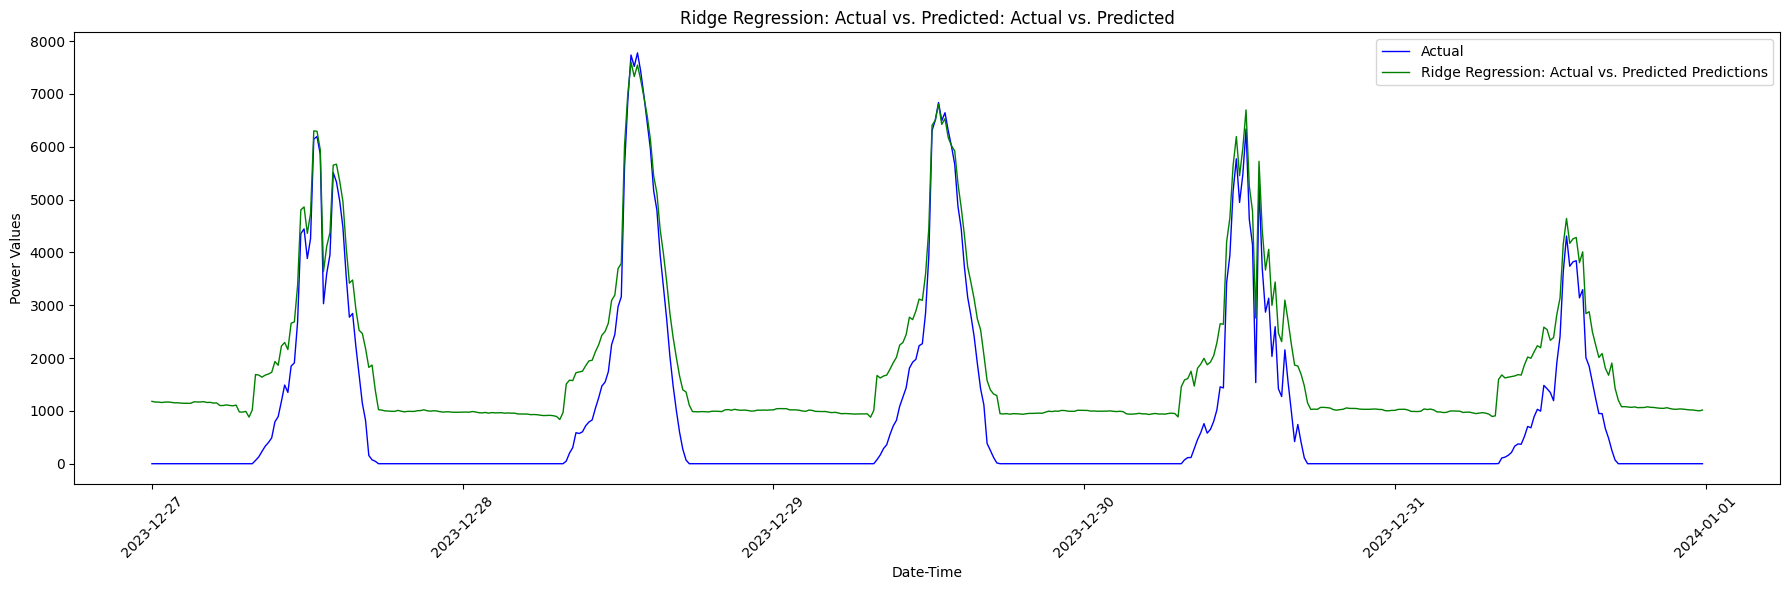

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


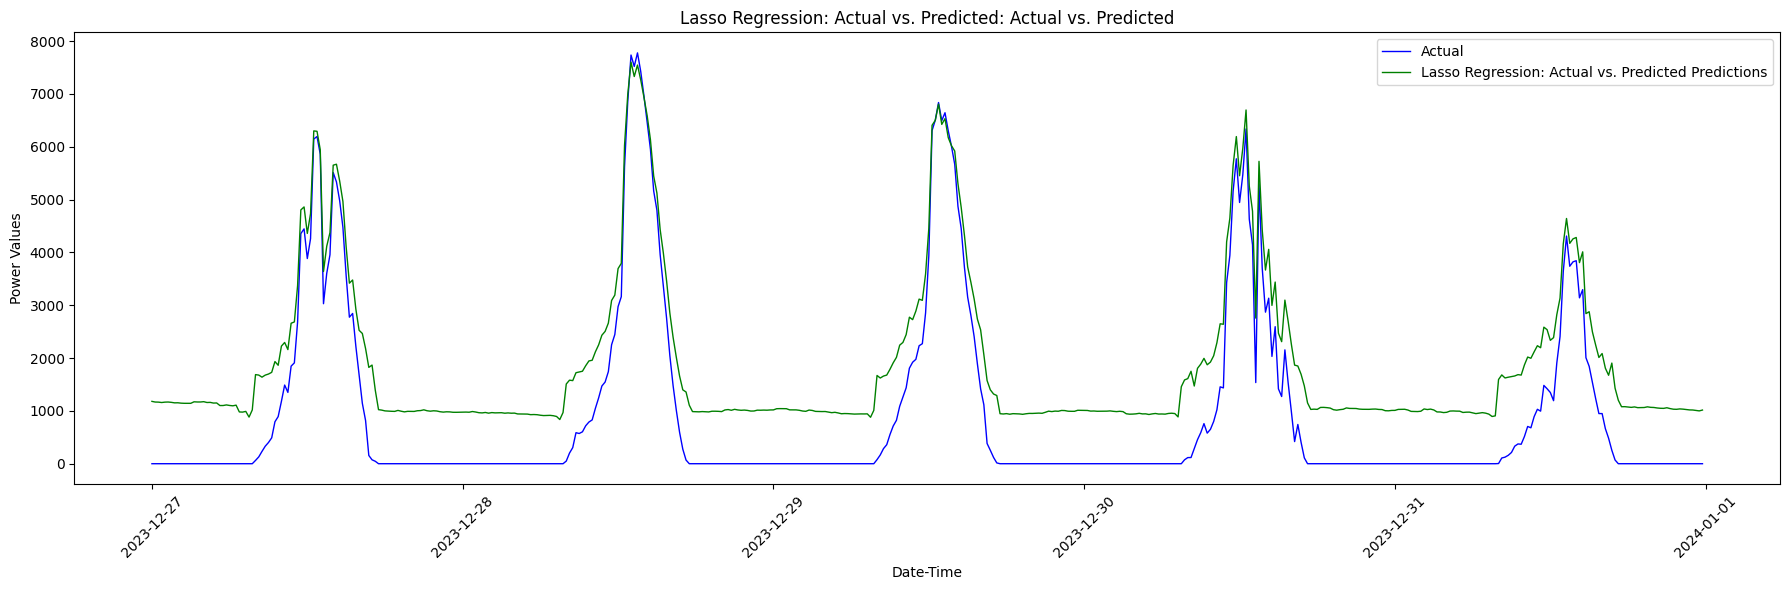

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


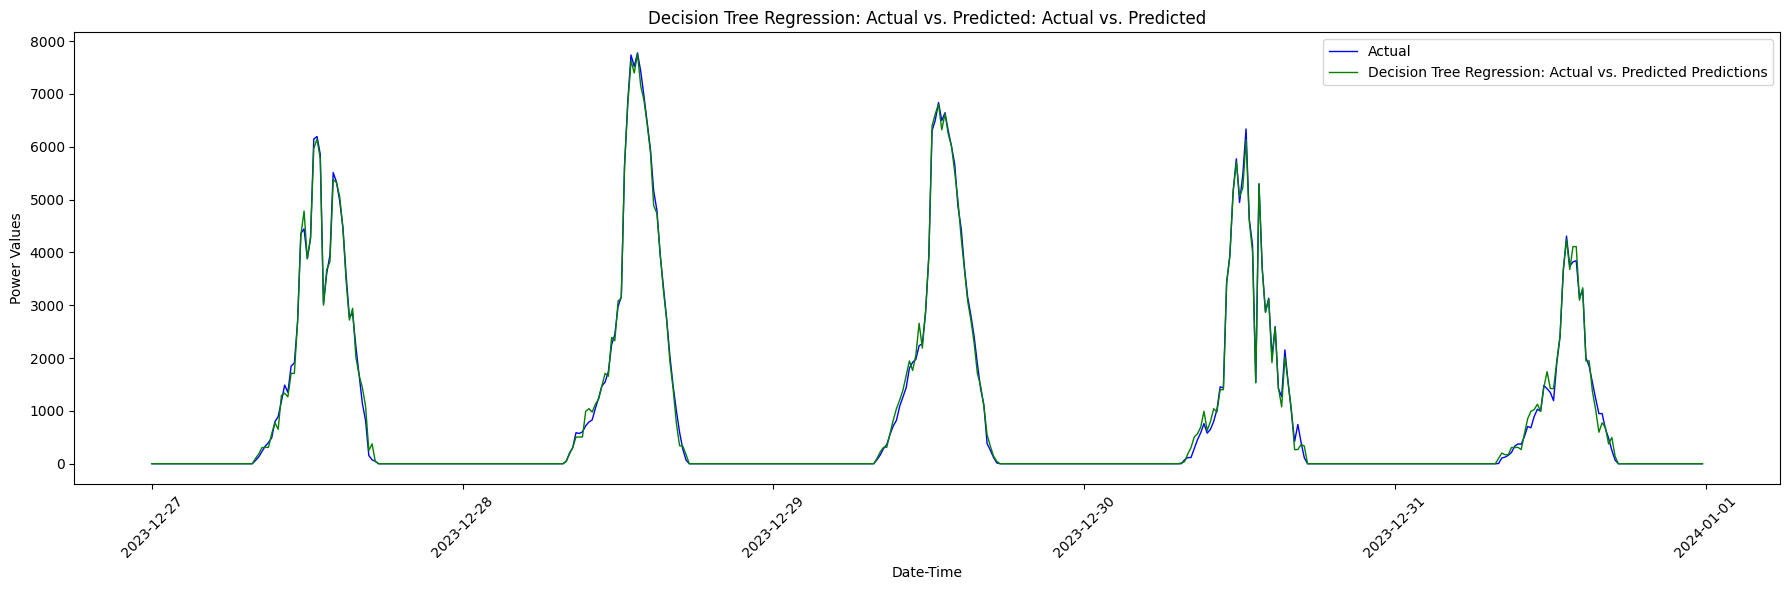

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


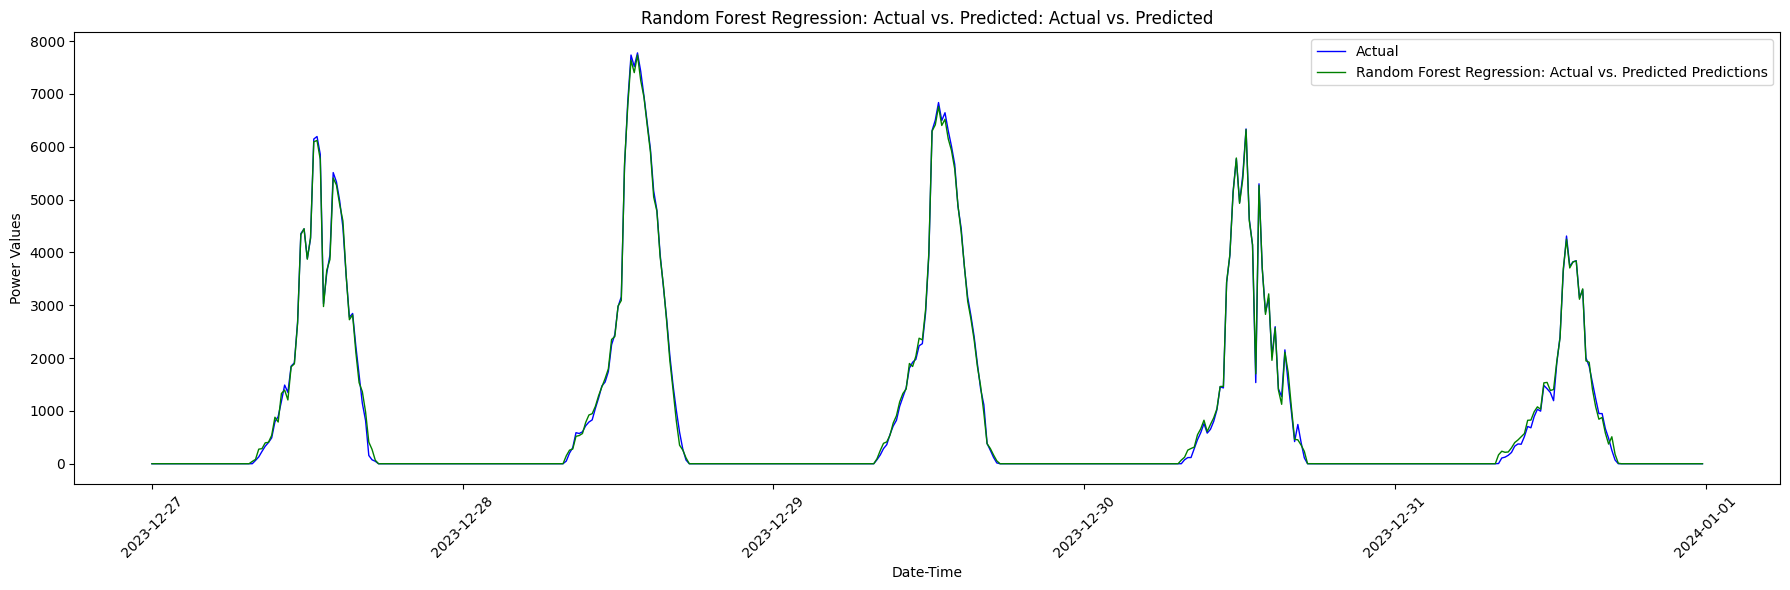

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


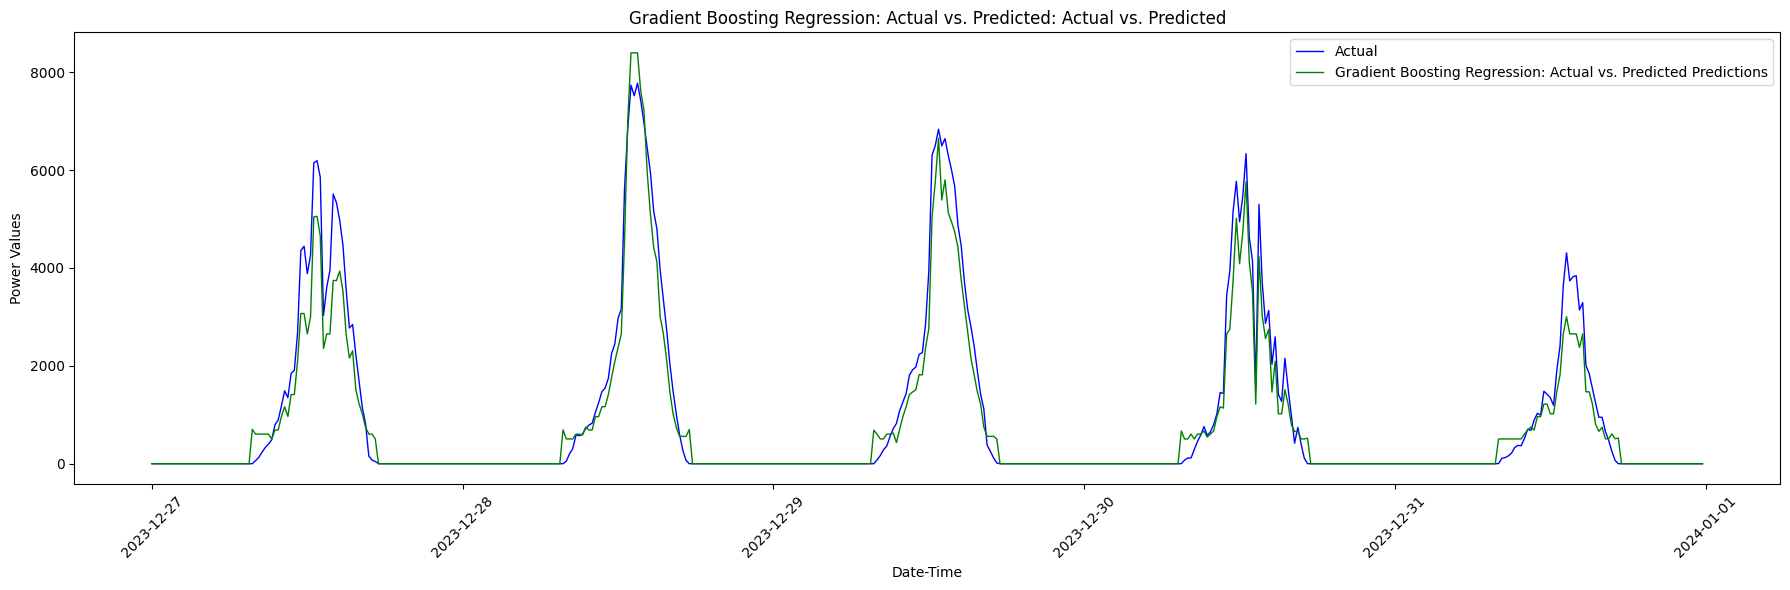

In [60]:
def plot_actual_vs_predicted(y_test, y_pred, metric_dates, title="Model", model_name=None):
    plt.figure(figsize=(18, 6))

    plt.plot(metric_dates, y_test.values, linestyle='-', marker='', label='Actual', color='blue', linewidth=1)

    plt.plot(metric_dates, y_pred, linestyle='-', marker='', label=f'{model_name if model_name else title} Predictions', color='green', linewidth=1)

    plt.xlabel('Date-Time')
    plt.ylabel('Power Values')

    plt.title(f'{model_name if model_name else title}: Actual vs. Predicted')
    plt.legend()

    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Convert metric_time to hh:mm:ss format
# Convert metric_time to hh:mm:ss format, handling AM/PM and converting to 24-hour time format
data['metric_time'] = pd.to_datetime(data['metric_time'], format='%I:%M:%S %p', errors='coerce').dt.strftime('%H:%M:%S')



# Plot comparison
metric_dates = pd.to_datetime(data['metric_date']) + pd.to_timedelta(data['metric_time'].astype(str))
# Create the metric_dates string
# metric_dates = data['metric_date'].astype(str) + ' ' + data['metric_time'].astype(str)


# Plotting the results for individual models with the updated function
y_pred_linear = ensure_non_zero(linear_model.predict(X_test))
plot_actual_vs_predicted_line(y_test, y_pred_linear, 'Linear Regression: Actual vs. Predicted', metric_dates[X_test.index])

y_pred_poly = ensure_non_zero(poly_model.predict(X_test_poly))
plot_actual_vs_predicted_line(y_test, y_pred_poly, 'Polynomial Regression: Actual vs. Predicted', metric_dates[X_test.index])

y_pred_ridge = ensure_non_zero(ridge_best_model.predict(X_test))
plot_actual_vs_predicted_line(y_test, y_pred_ridge, 'Ridge Regression: Actual vs. Predicted', metric_dates[X_test.index])

y_pred_lasso = ensure_non_zero(lasso_best_model.predict(X_test))
plot_actual_vs_predicted_line(y_test, y_pred_lasso, 'Lasso Regression: Actual vs. Predicted', metric_dates[X_test.index])

y_pred_tree = ensure_non_zero(tree_model.predict(X_test))
plot_actual_vs_predicted_line(y_test, y_pred_tree, 'Decision Tree Regression: Actual vs. Predicted', metric_dates[X_test.index])

y_pred_forest = ensure_non_zero(forest_model.predict(X_test))
plot_actual_vs_predicted_line(y_test, y_pred_forest, 'Random Forest Regression: Actual vs. Predicted', metric_dates[X_test.index])

y_pred_gb = ensure_non_zero(gb_model.predict(X_test))
plot_actual_vs_predicted_line(y_test, y_pred_gb, 'Gradient Boosting Regression: Actual vs. Predicted', metric_dates[X_test.index])


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


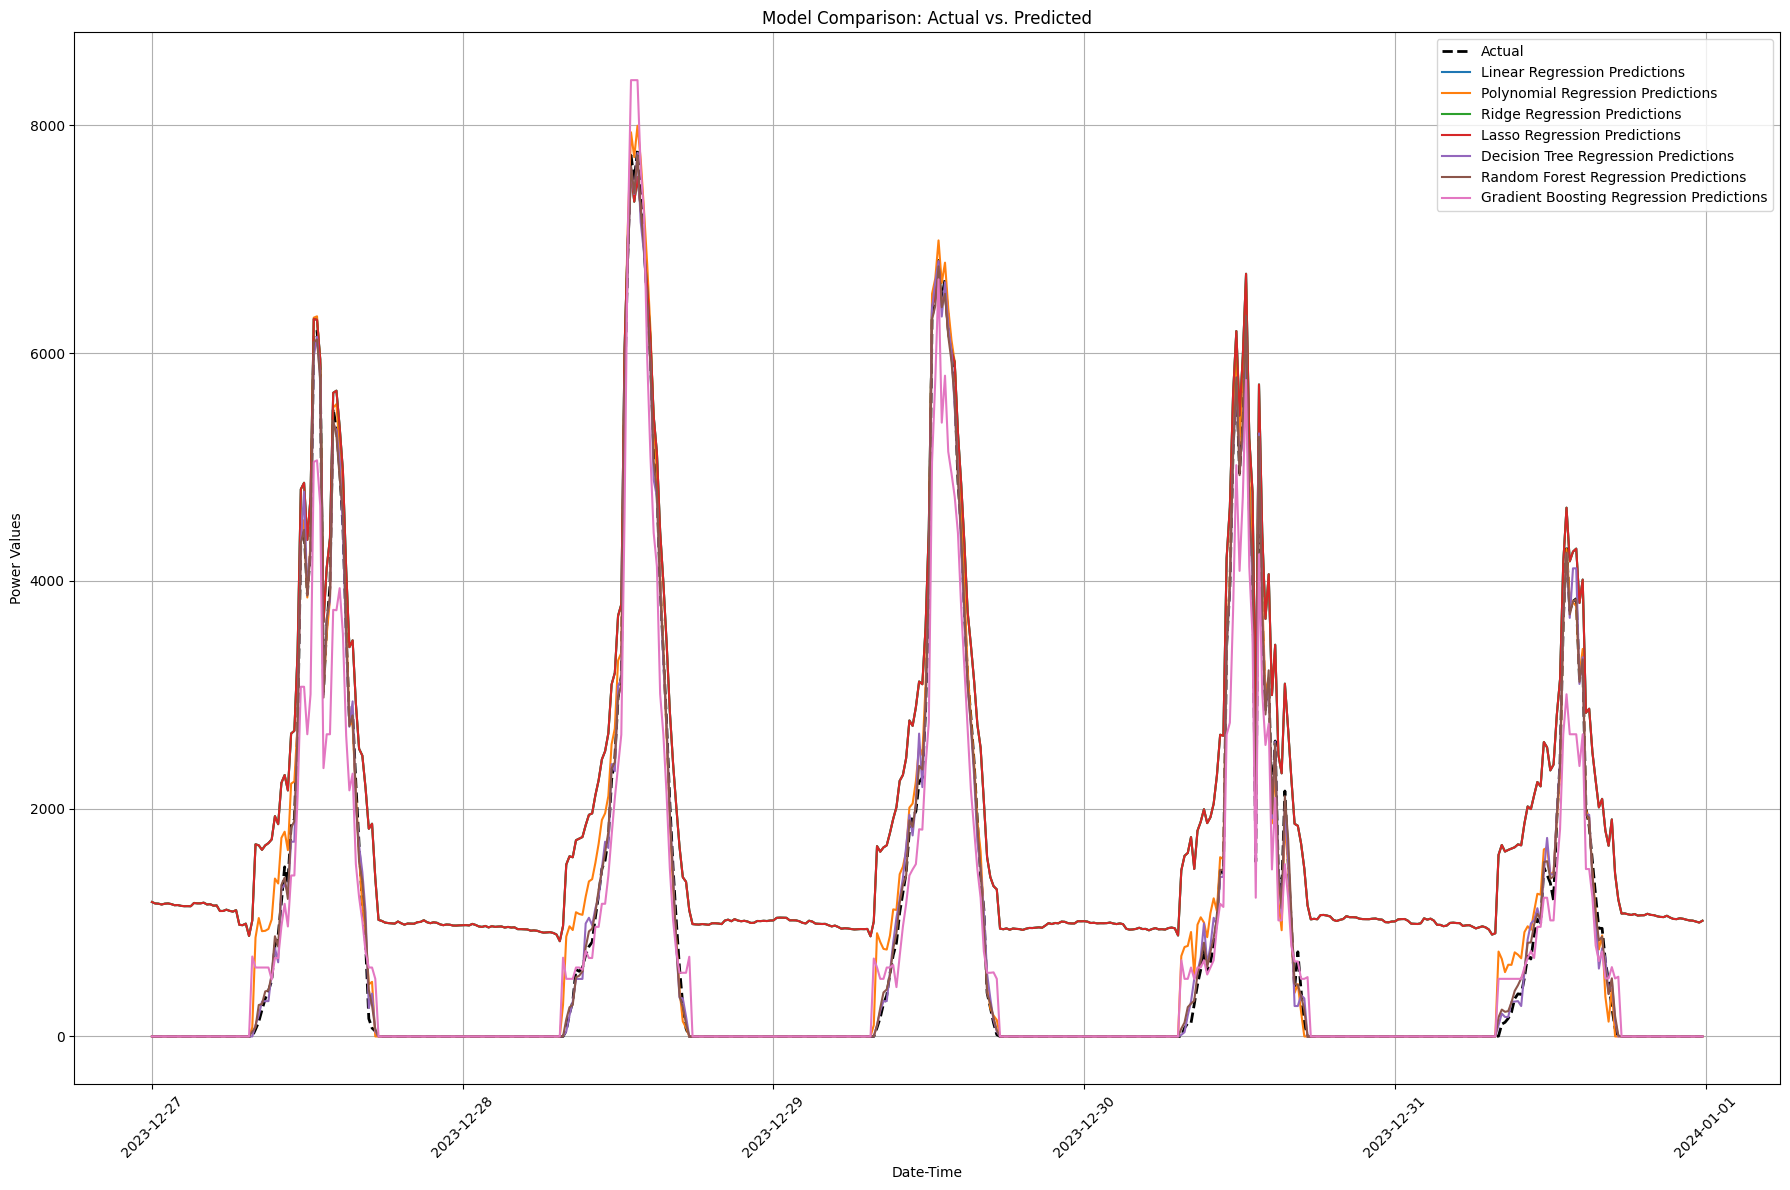

In [61]:
# Define a function to plot all models together for comparison
def plot_comparison(y_test, predictions_dict, metric_dates):
    plt.figure(figsize=(18, 12))

    # Plot actual values
    plt.plot(metric_dates, y_test.values, label='Actual', color='black', linestyle='--', linewidth=2)

    # Plot predictions for each model
    for model_name, y_pred in predictions_dict.items():
        plt.plot(metric_dates, y_pred, label=f'{model_name} Predictions')

    plt.xlabel('Date-Time')
    plt.ylabel('Power Values')
    plt.title('Model Comparison: Actual vs. Predicted')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate predictions for all models
y_pred_linear = ensure_non_zero(linear_model.predict(X_test))
y_pred_poly = ensure_non_zero(poly_model.predict(X_test_poly))
y_pred_ridge = ensure_non_zero(ridge_best_model.predict(X_test))
y_pred_lasso = ensure_non_zero(lasso_best_model.predict(X_test))
y_pred_tree = ensure_non_zero(tree_model.predict(X_test))
y_pred_forest = ensure_non_zero(forest_model.predict(X_test))
y_pred_gb = ensure_non_zero(gb_model.predict(X_test))

# Dictionary of predictions
predictions_dict = {
    'Linear Regression': y_pred_linear,
    'Polynomial Regression': y_pred_poly,
    'Ridge Regression': y_pred_ridge,
    'Lasso Regression': y_pred_lasso,
    'Decision Tree Regression': y_pred_tree,
    'Random Forest Regression': y_pred_forest,
    'Gradient Boosting Regression': y_pred_gb
}

# Plot comparison
plot_comparison(y_test, predictions_dict, metric_dates[X_test.index])

In [62]:
# Results from the models
results = {
    "Linear Regression": linear_r2,
    "Polynomial Regression": poly_r2,
    "Ridge Regression": ridge_r2,
    "Lasso Regression": lasso_r2,
    "Decision Tree Regression": tree_r2,
    "Random Forest Regression": forest_r2,
    "Gradient Boosting Regression": gb_r2
}

# Find the model with the maximum R2 score
best_model_name = max(results, key=results.get)
best_r2_score = results[best_model_name]

print(f"The model with the highest R2 score is: {best_model_name} with R2 score: {best_r2_score}")


The model with the highest R2 score is: Random Forest Regression with R2 score: 0.9989009702716551


In [63]:
# Generate predictions using the best model
def get_best_model_predictions(model_name, models_dict, X_test):
    if model_name in models_dict:
        model = models_dict[model_name]
        return ensure_non_zero(model.predict(X_test))
    else:
        raise ValueError(f"Model {model_name} not found in models_dict")

# Dictionary of models for prediction
models_dict = {
    "Linear Regression": linear_model,
    "Polynomial Regression": poly_model,
    "Ridge Regression": ridge_best_model,
    "Lasso Regression": lasso_best_model,
    "Decision Tree Regression": tree_model,
    "Random Forest Regression": forest_model,
    "Gradient Boosting Regression": gb_model
}

# Get predictions from the best model
y_pred_best = get_best_model_predictions(best_model_name, models_dict, X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


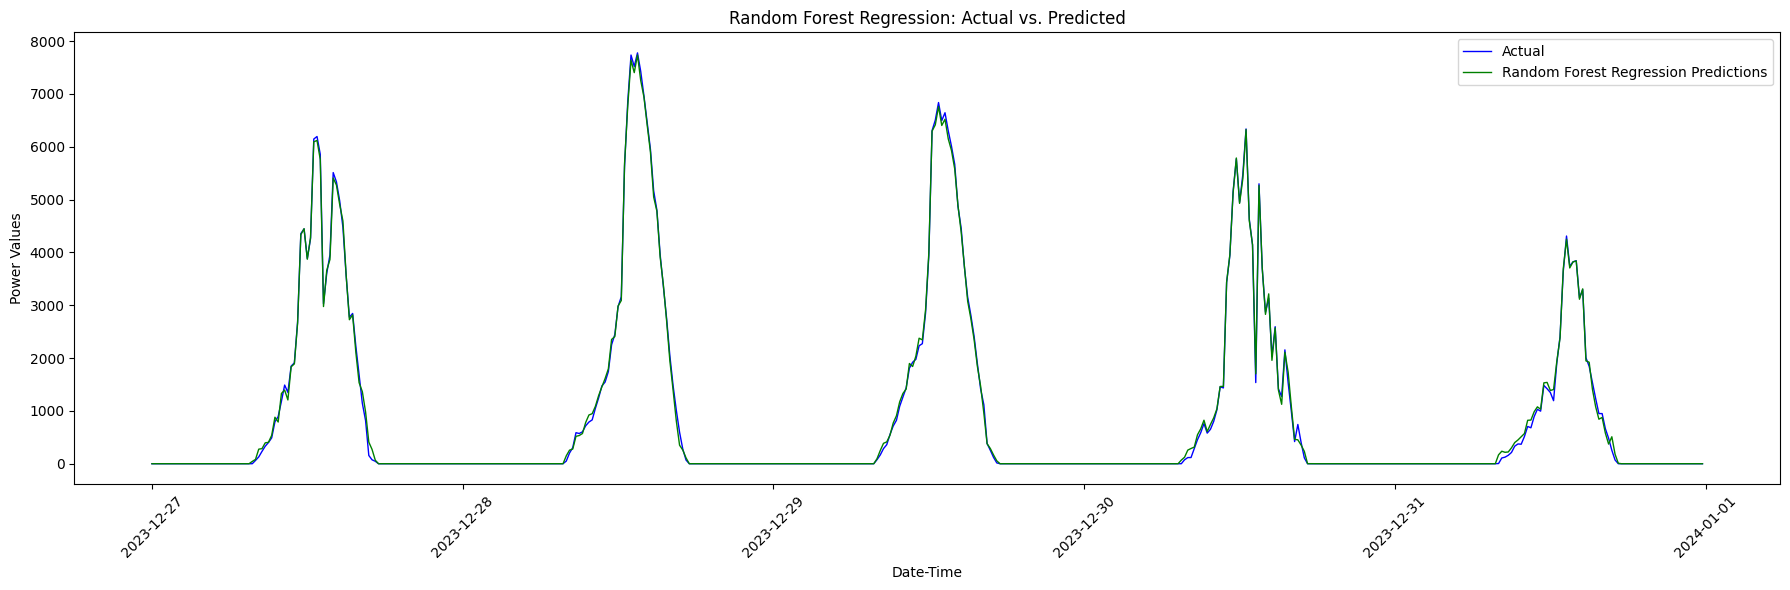

In [64]:
# Plot the best model's results
def plot_best_model_vs_actual(y_test, y_pred_best, metric_dates, model_name):
    plt.figure(figsize=(18, 6))

    plt.plot(metric_dates, y_test.values, linestyle='-', marker='', label='Actual', color='blue', linewidth=1)

    plt.plot(metric_dates, y_pred_best, linestyle='-', marker='', label=f'{model_name} Predictions', color='green', linewidth=1)

    plt.xlabel('Date-Time')
    plt.ylabel('Power Values')

    plt.title(f'{model_name}: Actual vs. Predicted')
    plt.legend()

    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Plot results for the best model
plot_best_model_vs_actual(y_test, y_pred_best, metric_dates[X_test.index], best_model_name)
